Test random forest, logistic regression and XG boost for the decade target feature with 5-fold cross validation and hyperparameter tuning by grid search.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#import data 
df=pd.read_csv('../../data/data_train_all.csv')
data_columns=pd.read_csv('../../data/data_train_all_columns.csv')

Remove highly correlated features (magnitude of R above 0.7) and use lasso to reduce list of features to top 20 most important.

In [62]:
from modeling.functions_L1_regularization import run_classification_lasso

In [63]:
predictor_ngrams_columns = data_columns[data_columns['column_type'] == 'predictor_n_grams']['column_name'].tolist()

In [64]:

uncorrelated_columns_7=predictor_ngrams_columns.copy()
while True:
    new_corr_matrix = df[uncorrelated_columns_7].corr()
    new_high_corr = new_corr_matrix.where(
        (new_corr_matrix.abs() > 0.7) & (new_corr_matrix != 1.0)
        ).stack().sort_values(ascending=False)
    if len(new_high_corr)==0:
        break
    pairs=new_high_corr.index.to_list()
    unnest_pairs=[i for j in pairs for i in j]
    pair_dict=Counter(unnest_pairs)
    sorted_keys = sorted(pair_dict, key=pair_dict.get, reverse=True)
    uncorrelated_columns_7.remove(sorted_keys[0])



In [65]:
#42 of the original 109 n-gram features have been removed
len(uncorrelated_columns_7)

67

In [66]:
#list of removed features
bad_columns_7=[x for x in predictor_ngrams_columns if x not in uncorrelated_columns_7]
#create new list of predictor columns with 42 features removed
predictor_columns_7 = data_columns[data_columns['column_type'].isin(['predictor_n_grams', 'predictor_continuous'])]['column_name'].tolist()
for item in bad_columns_7:
    predictor_columns_7.remove(item)

Training Lasso (L1) for: decade
Total data size: 255606
Using 5-fold cross-validation

Cross-validation accuracy scores: [0.43048003 0.43154477 0.4316817  0.43170126 0.43252284]
Mean CV accuracy: 0.4316 (+/- 0.0007)

Classification Report:
              precision    recall  f1-score   support

      1950.0       0.00      0.00      0.00      1098
      1960.0       0.13      0.00      0.00      6650
      1970.0       0.15      0.01      0.01     11741
      1980.0       0.13      0.00      0.00     13954
      1990.0       0.22      0.00      0.01     28002
      2000.0       0.29      0.13      0.18     58278
      2010.0       0.45      0.94      0.61    109125
      2020.0       0.00      0.00      0.00     26758

    accuracy                           0.43    255606
   macro avg       0.17      0.14      0.10    255606
weighted avg       0.30      0.43      0.30    255606



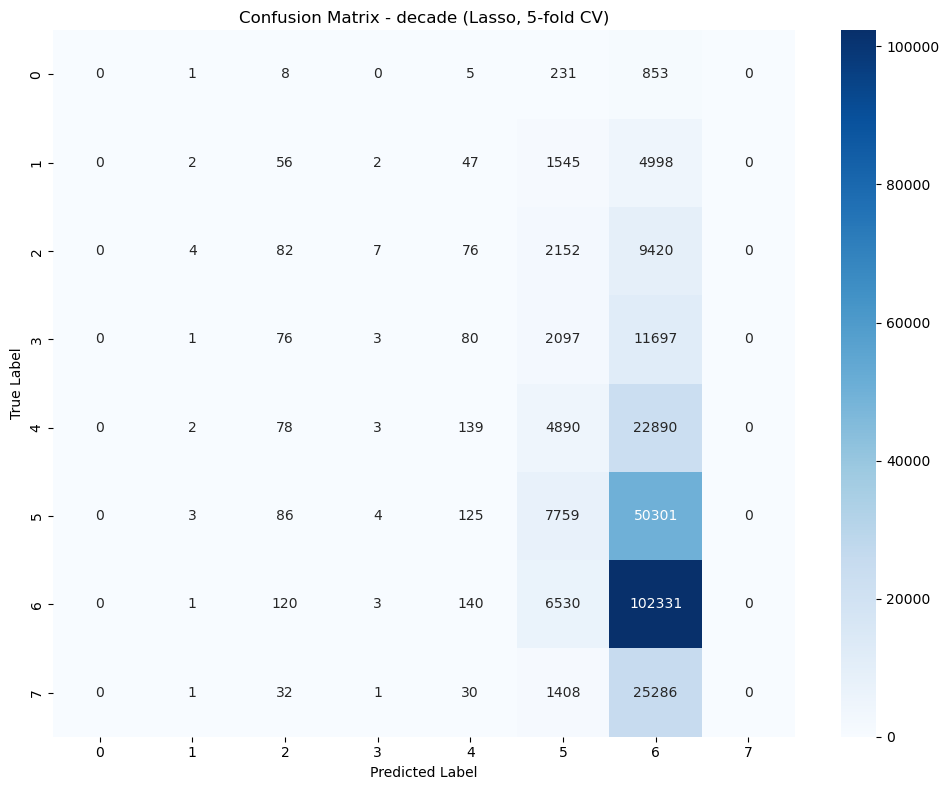


Number of features selected: 77 out of 77

Top 20 features for decade:
                 feature  importance
5       average_4overlap      1.5822
2        min_triad_ratio      1.3339
7       average_2overlap      1.3302
54        contains_G,C,G      0.8762
9            drone_ratio      0.8538
8        average_overlap      0.8515
48     contains_Emin,C,G      0.7627
46     contains_G,Amin,F      0.7624
0   unique_chord_density      0.7118
32     contains_F,Amin,G      0.7022
41     contains_F,G,Amin      0.6741
6       average_3overlap      0.6732
70   contains_F,C,G,Amin      0.6436
1   unique_5gram_density      0.5945
3        maj_triad_ratio      0.5706
44     contains_Amin,G,F      0.5684
4       average_5overlap      0.5590
50        contains_C,D,G      0.5477
56     contains_G,C,Emin      0.5273
72     contains_G,D,Amin      0.4919


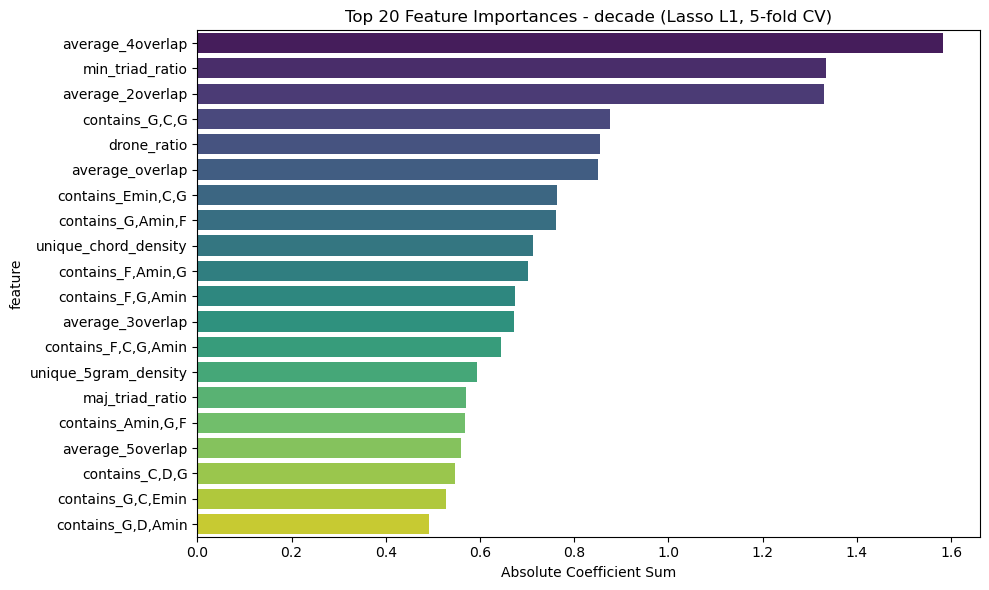

In [67]:
decade_importance_7 = run_classification_lasso(df,predictor_columns_7, 'decade','.', is_binary=False,savefile=False)

In [3]:
decade_7_vars=['average_4overlap','min_triad_ratio','average_2overlap','contains_G,C,G',
               'drone_ratio','average_overlap','contains_Emin,C,G','contains_G,Amin,F',
               'unique_chord_density','contains_F,Amin,G','contains_F,G,Amin',
               'average_3overlap','contains_F,C,G,Amin','unique_5gram_density',
               'maj_triad_ratio','contains_Amin,G,F','average_5overlap','contains_C,D,G',
               'contains_G,C,Emin','contains_G,D,Amin']
decade_df_7=df[decade_7_vars]

Grid serarch random forest

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [6]:
cv_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_grid={'max_depth':[5,10,15,20],'n_estimators':[50,100,150,200]}

In [71]:
grid_cv_decade_7 = GridSearchCV(RandomForestClassifier(random_state=42,n_jobs=-1), 
                                param_grid = rf_grid,scoring = 'accuracy',cv = cv_fold)  
grid_cv_decade_7.fit(df[decade_7_vars],df['decade'])


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [5, 10, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [72]:
print(grid_cv_decade_7.best_score_)
print(grid_cv_decade_7.best_params_)

0.4340078135116521
{'max_depth': 15, 'n_estimators': 200}


In [83]:
print(grid_cv_decade_7.cv_results_['params'])
print(grid_cv_decade_7.cv_results_['mean_test_score'])

[{'max_depth': 5, 'n_estimators': 50}, {'max_depth': 5, 'n_estimators': 100}, {'max_depth': 5, 'n_estimators': 150}, {'max_depth': 5, 'n_estimators': 200}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 150}, {'max_depth': 10, 'n_estimators': 200}, {'max_depth': 15, 'n_estimators': 50}, {'max_depth': 15, 'n_estimators': 100}, {'max_depth': 15, 'n_estimators': 150}, {'max_depth': 15, 'n_estimators': 200}, {'max_depth': 20, 'n_estimators': 50}, {'max_depth': 20, 'n_estimators': 100}, {'max_depth': 20, 'n_estimators': 150}, {'max_depth': 20, 'n_estimators': 200}]
[0.42993122 0.4296691  0.4296691  0.42971605 0.43364397 0.4336518
 0.43368309 0.43373004 0.43271676 0.43378481 0.4338748  0.43400781
 0.4267349  0.42911747 0.43023247 0.43065891]


Grid search logistic regression:

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
lr_grid={'logistic__penalty':[None,'l1','l2'],'logistic__C':[.01,.1,1,10,100]}
lr_model = Pipeline([
            ('scaler', StandardScaler()),
            ('logistic', LogisticRegression(solver='saga',max_iter=1000,random_state=42,
                n_jobs=-1))])


In [ ]:
grid_lr_decade=GridSearchCV(lr_model, param_grid = lr_grid,
                                scoring = 'accuracy',cv = cv_fold)  
grid_lr_decade.fit(df[decade_7_vars],df['decade'])

In [75]:
print(grid_lr_decade.best_score_)
print(grid_lr_decade.best_params_)

0.4310423088886502
{'logistic__C': 0.01, 'logistic__penalty': 'l1'}


In [82]:
print(grid_lr_decade.cv_results_['params'])
print(grid_lr_decade.cv_results_['mean_test_score'])

[{'logistic__C': 0.01, 'logistic__penalty': None}, {'logistic__C': 0.01, 'logistic__penalty': 'l1'}, {'logistic__C': 0.01, 'logistic__penalty': 'l2'}, {'logistic__C': 0.1, 'logistic__penalty': None}, {'logistic__C': 0.1, 'logistic__penalty': 'l1'}, {'logistic__C': 0.1, 'logistic__penalty': 'l2'}, {'logistic__C': 1, 'logistic__penalty': None}, {'logistic__C': 1, 'logistic__penalty': 'l1'}, {'logistic__C': 1, 'logistic__penalty': 'l2'}, {'logistic__C': 10, 'logistic__penalty': None}, {'logistic__C': 10, 'logistic__penalty': 'l1'}, {'logistic__C': 10, 'logistic__penalty': 'l2'}, {'logistic__C': 100, 'logistic__penalty': None}, {'logistic__C': 100, 'logistic__penalty': 'l1'}, {'logistic__C': 100, 'logistic__penalty': 'l2'}]
[0.43092885 0.43104231 0.43098363 0.43092885 0.43095624 0.43093277
 0.43092885 0.43093277 0.43092885 0.43092885 0.43092885 0.43092885
 0.43092885 0.43092885 0.43092885]


Grid search XG Boost

In [7]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

boost_grid={'max_depth':[2,4,6,8],'n_estimators':[50,100,150,200]}

boost_model=XGBClassifier()

grid_boost_decade=GridSearchCV(boost_model, param_grid = boost_grid,
                                scoring = 'accuracy',cv = cv_fold)  
grid_boost_decade.fit(df[decade_7_vars],le.fit_transform(y=df['decade']))

,estimator,"XGBClassifier...ate=None, ...)"
,param_grid,"{'max_depth': [2, 4, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [8]:
print(grid_boost_decade.best_score_)
print(grid_boost_decade.best_params_)

0.4341408259734097
{'max_depth': 4, 'n_estimators': 50}


In [9]:
print(grid_boost_decade.cv_results_['params'])
print(grid_boost_decade.cv_results_['mean_test_score'])

[{'max_depth': 2, 'n_estimators': 50}, {'max_depth': 2, 'n_estimators': 100}, {'max_depth': 2, 'n_estimators': 150}, {'max_depth': 2, 'n_estimators': 200}, {'max_depth': 4, 'n_estimators': 50}, {'max_depth': 4, 'n_estimators': 100}, {'max_depth': 4, 'n_estimators': 150}, {'max_depth': 4, 'n_estimators': 200}, {'max_depth': 6, 'n_estimators': 50}, {'max_depth': 6, 'n_estimators': 100}, {'max_depth': 6, 'n_estimators': 150}, {'max_depth': 6, 'n_estimators': 200}, {'max_depth': 8, 'n_estimators': 50}, {'max_depth': 8, 'n_estimators': 100}, {'max_depth': 8, 'n_estimators': 150}, {'max_depth': 8, 'n_estimators': 200}]
[0.43334664 0.43360485 0.4334953  0.43356964 0.43414083 0.43354225
 0.43316276 0.43265025 0.43284978 0.43083887 0.42871842 0.42704006
 0.42874581 0.4239924  0.42103081 0.41787361]


Compare dummy classifier with the best-performing model:

In [84]:
from modeling.functions import evaluate_dummy_baseline

evaluate_dummy_baseline(df[decade_7_vars],df['decade'],cv=cv_fold, target_variable='decade')


Evaluating Dummy Baseline...
Cross-validation folds: 5

Dummy Baseline (decade) - Multiclass Target
Parameters: strategy=most_frequent

Test Performance (Out-of-Sample):
------------------------------------------------------------
Accuracy                      :  0.4269 (+/- 0.0000)
Precision Micro               :  0.4269 (+/- 0.0000)




{'fit_time': array([0.03978205, 0.03299356, 0.03380489, 0.03493881, 0.03447986]),
 'score_time': array([0.00995779, 0.00897646, 0.00898576, 0.00903964, 0.00799799]),
 'test_accuracy': array([0.42691992, 0.42692827, 0.42692827, 0.42692827, 0.42692827]),
 'test_precision_micro': array([0.42691992, 0.42692827, 0.42692827, 0.42692827, 0.42692827])}

The best model of all the above is XG Boost classifier with a max depth of 4 and 50 estimators, which has an accuracy of about .007 greater on average than the dummy classifier.

Final test:

In [ ]:
test_df=pd.read_csv('~\Downloads\data_test_all.csv')

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(le.fit_transform(test_df['decade']),grid_boost_decade.predict(test_df[decade_7_vars]))

0.4353647992551045

Text(0, 0.5, 'Average out-of-fold accuracy')

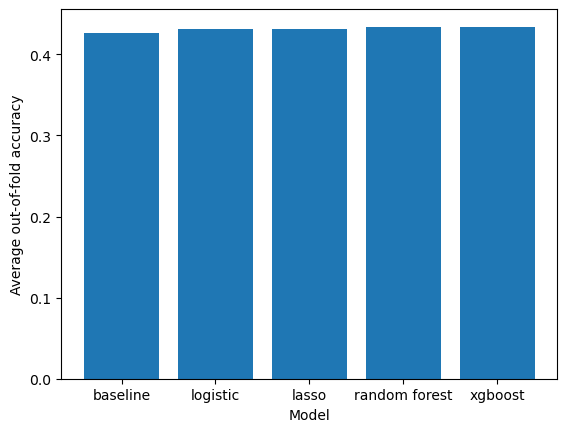

In [14]:
models=['baseline','logistic','lasso', 'random forest', 'xgboost']
values=[.4269,.43093,.43104,.43401,.43414]
plt.bar(models,values)
plt.xlabel('Model')
plt.ylabel('Average out-of-fold accuracy')